In [1]:
import scipy.io as spio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from random import shuffle

In [2]:
from keras.models import Sequential, save_model, load_model, clone_model
from keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasRegressor
from keras import callbacks
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import bayes_opt

Using TensorFlow backend.


In [3]:
sns.set(style='darkgrid')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bam/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
plt.rcParams['figure.figsize'] = (20.0, 6.0)

## Config options

In [5]:
preprocessing_params = {'total_folds': 6,
                        'validation_split': 0.2,
                        'augs_per_obs': 50}

nn_training_params = {'activ_types': ['relu', 'elu', 'tanh'],
                      'hidden_sizes': [2 ** i for i in range(3, 11)],
                      'save_final_n': 10,
                      'es_patience': 100,
                      'es_min_delta': 0.0005}

best_params = {'batch_size': 1000,
               'num_hidden_layers': 4,
               'start_activ': 'relu',
               'mid_activ': 'relu',
               'end_activ': 'relu',
               'dropout': 0.3,
               'first_hidden_size': 1024,
               'last_hidden_size': 1024}

## Dataset Description

This dataset is a subset of GDB-13 (a database of nearly 1 billion stable and synthetically accessible organic molecules) composed of all molecules of up to 23 atoms (including 7 heavy atoms C, N, O, and S), totalling 7165 molecules. We provide the Coulomb matrix representation of these molecules and their atomization energies computed similarly to the FHI-AIMS implementation of the Perdew-Burke-Ernzerhof hybrid functional (PBE0). This dataset features a large variety of molecular structures such as double and triple bonds, cycles, carboxy, cyanide, amide, alcohol and epoxy. The Coulomb matrix is defined as

$$ \begin{align*} C_{ii} = \frac{1}{2}Z_i^{2.4} \\
 C_{ij} = \frac{Z_iZ_j}{|R_i - R_j|} \end{align*}$$
 
where Zi is the nuclear charge of atom i and Ri is its position. The Coulomb matrix has built-in invariance to translation and rotation of the molecule. The atomization energies are given in kcal/mol and are ranging from -800 to -2000 kcal/mol).

The dataset is composed of three multidimensional arrays X (7165 x 23 x 23), T (7165) and P (5 x 1433) representing the inputs (Coulomb matrices), the labels (atomization energies) and the splits for cross-validation, respectively. The dataset also contain two additional multidimensional arrays Z (7165 x 23) and R (7165 x 23 x 3) representing the atomic charge and the cartesian coordinate of each atom in the molecules.

In [6]:
mat = spio.loadmat('data/qm7.mat', squeeze_me=True)

raw_X = mat['X']
raw_T = mat['T']
raw_Z = mat['Z']
raw_R = mat['R']

# Description of QM7b dataset

## Load dataset

In [7]:
mat_b = spio.loadmat('data/qm7b.mat', squeeze_me=True)

target_cols = ['E(PBE0)', 'Emax(ZINDO)', 'Imax(ZINDO)', 'HOMO(ZINDO)',
               'LUMO(ZINDO)', 'E_1st(ZINDO)', 'IP(ZINDO)', 'EA(ZINDO)',
               'HOMO(PBE0)', 'LUMO(PBE0)', 'HOMO(GW)', 'LUMO(GW)',
               'polariz(PBE0)', 'polariz(SCS)']

In [8]:
coulombs = mat_b['X']
targets = mat_b['T']
targets_df = pd.DataFrame(targets, columns=target_cols)
E_ref = targets[:, 0]

targets_df.head()

,E(PBE0),Emax(ZINDO),Imax(ZINDO),HOMO(ZINDO),LUMO(ZINDO),E_1st(ZINDO),IP(ZINDO),EA(ZINDO),HOMO(PBE0),LUMO(PBE0),HOMO(GW),LUMO(GW),polariz(PBE0),polariz(SCS)
0,-420.933746,39.694626,0.621841,-16.013,4.162,36.768073,15.72523,-3.98613,-10.9488,0.1323,-14.1341,1.0870,2.534576,2.43222
1,-718.419189,22.622486,0.628328,-13.549,3.684,11.717433,13.41121,-3.49181,-9.5577,0.1452,-12.5472,1.1186,4.332028,4.44500
2,-570.024841,22.940671,0.709060,-10.160,1.231,7.137266,9.75211,-0.82042,-7.8768,-0.0620,-10.4383,1.9456,4.173282,3.92308
3,-410.286163,15.973798,2.228480,-10.706,2.145,4.624107,10.46577,-1.89847,-8.4021,0.4143,-11.1629,1.1958,3.512394,3.32175
4,-868.855408,17.900516,0.556174,-12.365,3.825,10.311655,11.96491,-3.57487,-8.3534,0.2690,-10.8132,1.2002,5.480160,5.78632


## Memoization / loading memoized objects

In [9]:
def load_or_save_pickle(filename, generating_fn, *args, **kwargs):
    '''
    Saves or loads an object to/from pickle.
    Will generate the object and save if there is no pickle.
    Otherwise will load the object from pickle.
    
    Usage:  object = load_or_save_pickle(filename, generating_fn, *args, **kwargs)
            
    Inputs: filename - choose your filename
            generating_fn - the generating function that will construct the object you want to save,
                            this function defined elsewhere in your code
            *args / **kwargs - all arguments and keyword arguments you want to pass on to the generating function
    '''
    
    
    if 'pickles' not in os.listdir('.'):
        os.mkdir('pickles')
    
    filepath = f'{filename}.pkl'
    
    if filepath not in os.listdir('pickles'):
        temp = generating_fn(*args, **kwargs)
        
        with open(os.path.join('pickles', filepath), 'wb') as f:
            print(f'Saving {filename} to {filepath}')
            pickle.dump(temp, f)
            f.close()
            print('Save complete')
    
    else:
        print(f'{filename} already computed, loading from {filepath}')
        with open(os.path.join('pickles', filepath), 'rb') as f:
            temp = pickle.load(f)
            f.close()
            print('Load complete')
    
    return temp

## Train / validation / test splits

Stratify IAW sorted atomization energies E(PBE0)

In [10]:
features = coulombs.copy()

sorted_indices = np.argsort(targets[:, 0])
total_folds = preprocessing_params['total_folds']

split_labels = []
for _ in range(int(features.shape[0] / total_folds)):
    fold_nums = list(range(total_folds))
    np.random.shuffle(fold_nums)
    for fold_num in fold_nums.copy():
        split_labels.append(fold_num)

remaining_samples = features.shape[0] - int(features.shape[0] / total_folds) * total_folds
fold_nums = list(range(remaining_samples))
np.random.shuffle(fold_nums)
for fold_num in fold_nums.copy():
        split_labels.append(fold_num)

In [11]:
features = features[sorted_indices]
targets = targets[sorted_indices]

In [12]:
train_indices = [i for i in range(len(split_labels)) if split_labels[i] % total_folds in [2, 3, 4, 5]]
val_indices = [i for i in range(len(split_labels)) if split_labels[i] % total_folds == 1]
test_indices = [i for i in range(len(split_labels)) if split_labels[i]  % total_folds == 0]
print(len(train_indices))
print(len(val_indices))
print(len(test_indices))
assert (len(train_indices + val_indices + test_indices)) == coulombs.shape[0]

4807
1202
1202


In [13]:
shuffle(train_indices)
shuffle(val_indices)
shuffle(test_indices)

In [14]:
X_train = features[train_indices]
X_val = features[val_indices]
X_test = features[test_indices]

Y_train = targets[train_indices]
Y_val = targets[val_indices]
Y_test = targets[test_indices]

In [15]:
scaler = StandardScaler().fit(Y_train)
Y_train = scaler.transform(Y_train)
Y_val = scaler.transform(Y_val)
Y_test = scaler.transform(Y_test);

## Data Augmentation

In [16]:
def gen_augmented_coulomb(orig_matrix):
    orig_norms = np.linalg.norm(orig_matrix, axis=1)
    gauss_noise = np.random.normal(scale=orig_norms.std(), size=orig_norms.shape[0])
    noisy_norms = orig_norms + gauss_noise
    
    sorting_args = np.argsort(noisy_norms)[::-1]
    
    return orig_matrix[sorting_args].T[sorting_args]

In [17]:
def augment_features(samples, augments_per_sample):
    
    def augment_single(sample):
        return [gen_augmented_coulomb(sample) for _ in range(augments_per_sample)]

    return np.stack(np.vstack([samples, np.vstack([augment_single(sample) for sample in samples])]))

def augment_targets(samples, augments_per_sample):
    return np.stack(np.vstack([samples, np.vstack([[sample for _ in range(augments_per_sample)] for sample in samples])]))

In [18]:
augs_per_obs = preprocessing_params['augs_per_obs']

X_train_aug = augment_features(X_train, augs_per_obs)
Y_train_aug = augment_targets(Y_train, augs_per_obs)

X_train_aug = X_train_aug.copy().reshape(X_train_aug.shape[0], 529)

In [19]:
X_val_aug = augment_features(X_val, augs_per_obs)
Y_val_aug = augment_targets(Y_val, augs_per_obs)

X_val_aug = X_val_aug.copy().reshape(X_val_aug.shape[0], 529)

In [20]:
X_test_aug = augment_features(X_test, augs_per_obs)
Y_test_aug = augment_targets(Y_test, augs_per_obs)

X_test_aug = X_test_aug.copy().reshape(X_test_aug.shape[0], 529)

In [21]:
assert int((X_train_aug.shape[0] + X_val_aug.shape[0] + X_test_aug.shape[0]) / (1 + augs_per_obs)) == coulombs.shape[0]

## NN setup

In [22]:
def K_r2(y_true, y_pred):
    numerator = K.sum(K.square(y_true - y_pred))
    denominator = K.sum(K.square(y_true - K.mean(y_pred)))
    return 1 - numerator / denominator


def setup_NN(activation_types, hidden_units, dropouts, input_dim=529):
    nn_model = Sequential()
    
    # Input
    nn_model.add(Dense(units=hidden_units[0], input_dim=input_dim))
    nn_model.add(BatchNormalization())
    nn_model.add(Activation(activation_types[0]))
    nn_model.add(Dropout(dropouts[0]))
    
    # Hidden
    for i in range(1, len(hidden_units)):
        nn_model.add(Dense(units=hidden_units[i]))
        nn_model.add(BatchNormalization())
        nn_model.add(Activation(activation_types[i]))
        nn_model.add(Dropout(dropouts[i]))
    
    # Output
    nn_model.add(Dense(units=14, activation='linear'))
    
    # Final parameters
    nn_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[K_r2])
    
    return nn_model

## Tune some hyperparameters

### Define parameter spaces, mapping continuous values to (mostly) discrete ones
### Define framework for parameter optimization

In [23]:
def cast_params(batch_size, num_hidden_layers, start_activ, mid_activ, end_activ,
                dropout, first_hidden_size, last_hidden_size):
    
    print('Raw params:', [batch_size, num_hidden_layers, start_activ, mid_activ, end_activ,
                dropout, first_hidden_size, last_hidden_size])
    
    def safe(float_input):
        if abs(float_input - int(float_input)) < 0.001:
            return int(float_input - 0.001)
        else:
            return int(float_input)
    
    params = {}
    params['batch_size'] = 10 ** safe(batch_size)
    params['num_hidden_layers'] = safe(num_hidden_layers)
    params['start_activ'] = nn_training_params['activ_types'][safe(start_activ)]
    params['mid_activ'] = nn_training_params['activ_types'][safe(mid_activ)]
    params['end_activ'] = nn_training_params['activ_types'][safe(end_activ)]
    params['dropout'] = round(dropout, 2)
    params['first_hidden_size'] = nn_training_params['hidden_sizes'][safe(first_hidden_size)]
    params['last_hidden_size'] = nn_training_params['hidden_sizes'][safe(last_hidden_size)]
    
    history = test_nn_params(params).history['val_loss']
    
    print('Total epochs:', len(history))
    
    return -1 * history[-1]

In [24]:
def test_nn_params(params):
    print('Params: ', [params[param] for param in params])
    num_inner_layers = params['num_hidden_layers'] - 2
    activation_types = [params['start_activ']] + [params['mid_activ']] * num_inner_layers + [params['end_activ']]
    dropouts = [params['dropout']] * params['num_hidden_layers']
    hidden_units = list(np.geomspace(params['first_hidden_size'], params['last_hidden_size'], num=params['num_hidden_layers'], dtype=int32))
    
    test_model = setup_NN(activation_types, hidden_units, dropouts)
    callback_list = [callbacks.EarlyStopping(min_delta=0.01, patience=20)]
    
    return test_model.fit(x=X_train_aug, y=Y_train_aug,
                         batch_size=params['batch_size'], verbose=0,
                         epochs=1000, validation_data=(X_val_aug, Y_val_aug),
                         callbacks=callback_list)

In [25]:
pbounds = {'batch_size': (3, 5),
           'num_hidden_layers': (3, 7),
           'start_activ': (0, len(nn_training_params['activ_types'])),
           'mid_activ': (0, len(nn_training_params['activ_types'])),
           'end_activ': (0, len(nn_training_params['activ_types'])),
           'dropout': (0.1, 0.5),
           'first_hidden_size': (0, len(nn_training_params['hidden_sizes'])),
           'last_hidden_size': (0, len(nn_training_params['hidden_sizes']))}

In [26]:
# hyper_searcher = bayes_opt.BayesianOptimization(f=cast_params,
#                                                pbounds=pbounds,
#                                                verbose=2)

In [27]:
# hyper_searcher.maximize(init_points=6, n_iter=1)

# with open('pickles/hyper_searcher_1.pkl', 'wb') as f:
#     pickle.dump(hyper_searcher, f)
#     f.close()

In [28]:
# for i in range(2, 20):
#     hyper_searcher.maximize(n_iter=1)
#     with open('pickles/hyper_searcher_%d.pkl' % i, 'wb') as f:
#         pickle.dump(hyper_searcher, f)
#         f.close()

## Train to early stopping point

In [29]:
class WindowedCheckpoint(callbacks.Callback):
    """Save the model after every epoch.

    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and
    keys in `logs` (passed in `on_epoch_end`).

    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.

    # Arguments
        filepath: string, path to save the model file.
        monitor: quantity to monitor.
        verbose: verbosity mode, 0 or 1.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        mode: one of {auto, min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc. In `auto` mode, the direction is
            automatically inferred from the name of the monitored quantity.
        save_weights_only: if True, then only the model's weights will be
            saved (`model.save_weights(filepath)`), else the full model
            is saved (`model.save(filepath)`).
        period: Interval (number of epochs) between checkpoints.
    """

    def __init__(self, filepath, monitor='val_loss', verbose=0,
                 save_best_only=False, save_weights_only=False,
                 mode='auto', period=1):
        super(WindowedCheckpoint, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.filepath = filepath
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.period = period
        self.epochs_since_last_save = 0

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('ModelCheckpoint mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'

        if mode == 'min':
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epochs_since_last_save += 1
        if self.epochs_since_last_save >= self.period:
            self.epochs_since_last_save = 0
            filepath = self.filepath.format(epoch=((epoch + 1) % nn_training_params['save_final_n']), **logs)
            if self.save_best_only:
                current = logs.get(self.monitor)
                if current is None:
                    warnings.warn('Can save best model only with %s available, '
                                  'skipping.' % (self.monitor), RuntimeWarning)
                else:
                    if self.monitor_op(current, self.best):
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s improved from %0.5f to %0.5f,'
                                  ' saving model to %s'
                                  % (epoch + 1, self.monitor, self.best,
                                     current, filepath))
                        self.best = current
                        if self.save_weights_only:
                            self.model.save_weights(filepath, overwrite=True)
                        else:
                            self.model.save(filepath, overwrite=True)
                    else:
                        if self.verbose > 0:
                            print('\nEpoch %05d: %s did not improve from %0.5f' %
                                  (epoch + 1, self.monitor, self.best))
            else:
                if self.verbose > 0:
                    print('\nEpoch %05d: saving model to %s' % (epoch + 1, filepath))
                if self.save_weights_only:
                    self.model.save_weights(filepath, overwrite=True)
                else:
                    self.model.save(filepath, overwrite=True)

In [30]:
def setup_model(save_prefix, params, min_delta=0.01, patience=20):
    num_inner_layers = params['num_hidden_layers'] - 2
    activation_types = [params['start_activ']] + [params['mid_activ']] * num_inner_layers + [params['end_activ']]
    dropouts = [params['dropout']] * params['num_hidden_layers']
    hidden_units = list(np.geomspace(params['first_hidden_size'], params['last_hidden_size'], num=params['num_hidden_layers'], dtype=int32))
    batch_size = params['batch_size']
    
    model = setup_NN(activation_types, hidden_units, dropouts)
    
    filepath = 'model_checkpoints/' + str(save_prefix) + '.{epoch:0d}.hdf5'
    wc = WindowedCheckpoint(filepath, verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
    es = callbacks.EarlyStopping(min_delta=min_delta, patience=patience)
    
    callback_list = [wc, es]
    
    return model, callback_list, batch_size

def train_model(model, callback_list, batch_size):
    model.fit(x=X_train_aug, y=Y_train_aug,
              batch_size=batch_size, verbose=1,
              epochs=100000, validation_data=(X_val_aug, Y_val_aug),
              callbacks=callback_list)

In [31]:
def setup_and_train(save_prefix, params, min_delta=0.01, patience=20):
    model, callback_list, batch_size = setup_model(save_prefix, params, min_delta=min_delta, patience=patience)
    train_model(model, callback_list, batch_size)
    
    with open('pickles/' + save_prefix + '.pkl', 'wb') as f:
        pickle.dump(model, f)
        f.close()
    
    return model

## First model, with min_delta 0.0005, patience 100

In [32]:
# mark1_nn = setup_and_train('mark1_nn', best_params, min_delta=nn_training_params['es_min_delta'],
#                            patience=nn_training_params['es_patience'])

In [33]:
# mark1_nn_history = mark1_nn.history.history.copy()
# with open('pickles/mark1_nn_history.pkl', 'wb') as f:
#     pickle.dump(mark1_nn_history, f)
#     f.close()

## Load and average weights from last 10 epochs

In [34]:
def load_all_models(model_name):
    all_models = list()
    for epoch in [str(i) for i in range(10)]:
        # define filename for this ensemble
        filename = 'model_checkpoints/' + model_name + '.' + str(epoch) + '.hdf5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models.append(model)
        print('>loaded %s' % filename)
    return all_models

def model_weight_ensemble(members, weights):
    # determine how many layers need to be averaged
    n_layers = len(members[0].get_weights())
    # create an set of average model weights
    avg_model_weights = list()
    for layer in range(n_layers):
        # collect this layer from each model
        layer_weights = np.array([model.get_weights()[layer] for model in members])
        # weighted average of weights for this layer
        avg_layer_weights = np.average(layer_weights, axis=0, weights=weights)
        # store average layer weights
        avg_model_weights.append(avg_layer_weights)
    # create a new model with the same structure
    model = clone_model(members[0])
    # set the weights in the new
    model.set_weights(avg_model_weights)
    model.compile(loss='mean_absolute_error', metrics=['mean_absolute_error'], optimizer='adam')
    return model

def ensemble_epochs(model_name):
    # load all models into memory
    members = load_all_models(model_name)
    print('Loaded %d models' % len(members))
    # prepare an array of equal weights
    n_models = len(members)
    weights = [1/n_models for i in range(1, n_models+1)]
    # create a new model with the weighted average of all model weights
    model = model_weight_ensemble(members, weights)
    # summarize the created model
    model.summary()
    return model

In [36]:
from keras.utils.generic_utils import get_custom_objects

get_custom_objects().update({"K_r2": K_r2})

# mark1_nn = ensemble_epochs('mark1_nn')

W1008 13:18:08.794131 139776155772736 deprecation_wrapper.py:119] From /home/bam/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1008 13:18:08.816348 139776155772736 deprecation_wrapper.py:119] From /home/bam/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1008 13:18:08.888759 139776155772736 deprecation_wrapper.py:119] From /home/bam/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1008 13:18:08.889468 139776155772736 deprecation_wrapper.py:119] From /home/bam/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_def

>loaded model_checkpoints/mark1_nn.0.hdf5
>loaded model_checkpoints/mark1_nn.1.hdf5
>loaded model_checkpoints/mark1_nn.2.hdf5
>loaded model_checkpoints/mark1_nn.3.hdf5
>loaded model_checkpoints/mark1_nn.4.hdf5
>loaded model_checkpoints/mark1_nn.5.hdf5
>loaded model_checkpoints/mark1_nn.6.hdf5
>loaded model_checkpoints/mark1_nn.7.hdf5
>loaded model_checkpoints/mark1_nn.8.hdf5
>loaded model_checkpoints/mark1_nn.9.hdf5
Loaded 10 models
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              542720    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None,

## Save/load ensembled model

In [37]:
# with open('pickles/mark1_ensembled.pkl', 'wb') as f:
#     pickle.dump(mark1_nn, f)
#     f.close()

In [38]:
with open('pickles/mark1_ensembled.pkl', 'rb') as f:
    mark1_nn = pickle.load(f)
    f.close()

## Metrics for the model

In [39]:
print('Scaled MAE:', mean_absolute_error(Y_val_aug, mark1_nn.predict(X_val_aug)))
print('Scaled R^2:', r2_score(Y_val_aug, mark1_nn.predict(X_val_aug)))

Scaled MAE: 0.23760698203234915
Scaled R^2: 0.8153100124017925


In [40]:
Y_val_unscaled = scaler.inverse_transform(Y_val_aug)
Y_val_preds = scaler.inverse_transform(mark1_nn.predict(X_val_aug))

In [41]:
for i in range(14):
    print('R^2', target_cols[i], r2_score(Y_val_unscaled[:, i], Y_val_preds[:, i]))

R^2 E(PBE0) 0.9936221810781777
R^2 Emax(ZINDO) 0.5244128621388371
R^2 Imax(ZINDO) 0.7034033348453212
R^2 HOMO(ZINDO) 0.8027409052614992
R^2 LUMO(ZINDO) 0.8789363898401293
R^2 E_1st(ZINDO) 0.9148919178301376
R^2 IP(ZINDO) 0.7825547651235274
R^2 EA(ZINDO) 0.8758616457808933
R^2 HOMO(PBE0) 0.746959483061949
R^2 LUMO(PBE0) 0.809770127494994
R^2 HOMO(GW) 0.745637589140586
R^2 LUMO(GW) 0.7142353892651847
R^2 polariz(PBE0) 0.9376749592006303
R^2 polariz(SCS) 0.9836386266289759


In [42]:
print('MAE:', mean_absolute_error(Y_val_unscaled, Y_val_preds))
print('R^2:', r2_score(Y_val_unscaled, Y_val_preds))

MAE: 1.067166184883639
R^2: 0.8153100126207703


In [43]:
for i in range(14):
    print('Unscaled MAE', target_cols[i], mean_absolute_error(Y_val_unscaled[:, i], Y_val_preds[:, i]))

Unscaled MAE E(PBE0) 11.250558661549583
Unscaled MAE Emax(ZINDO) 1.2017825431612217
Unscaled MAE Imax(ZINDO) 0.06656822176427818
Unscaled MAE HOMO(ZINDO) 0.27706943221638425
Unscaled MAE LUMO(ZINDO) 0.2455976239554435
Unscaled MAE E_1st(ZINDO) 0.2729639794540811
Unscaled MAE IP(ZINDO) 0.2853408563221494
Unscaled MAE EA(ZINDO) 0.2573180937899609
Unscaled MAE HOMO(PBE0) 0.20671025205781873
Unscaled MAE LUMO(PBE0) 0.16809357792707585
Unscaled MAE HOMO(GW) 0.2290729358618211
Unscaled MAE LUMO(GW) 0.14568480766767167
Unscaled MAE polariz(PBE0) 0.20530973660709784
Unscaled MAE polariz(SCS) 0.12825586603625722


## Visualization

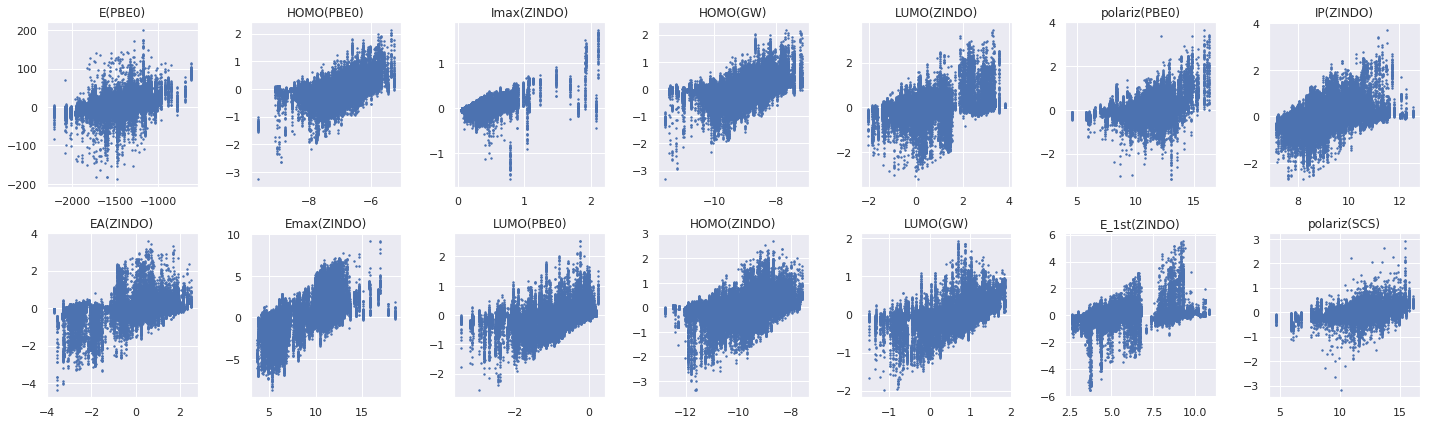

In [44]:
resid_plots = {target_cols[i]: [i % 2, i % 7] for i in range(14)}

fig, axes = plt.subplots(nrows=2, ncols=7)

for i, (k, v) in enumerate(resid_plots.items()):
    axes[resid_plots[k][0], resid_plots[k][1]].set_title(k)
    axes[resid_plots[k][0], resid_plots[k][1]].scatter(Y_val_unscaled[:, i], Y_val_unscaled[:, i] - Y_val_preds[:, i],
                                                      s=2)

plt.tight_layout()

for ax in fig.axes:
    plt.sca(ax)

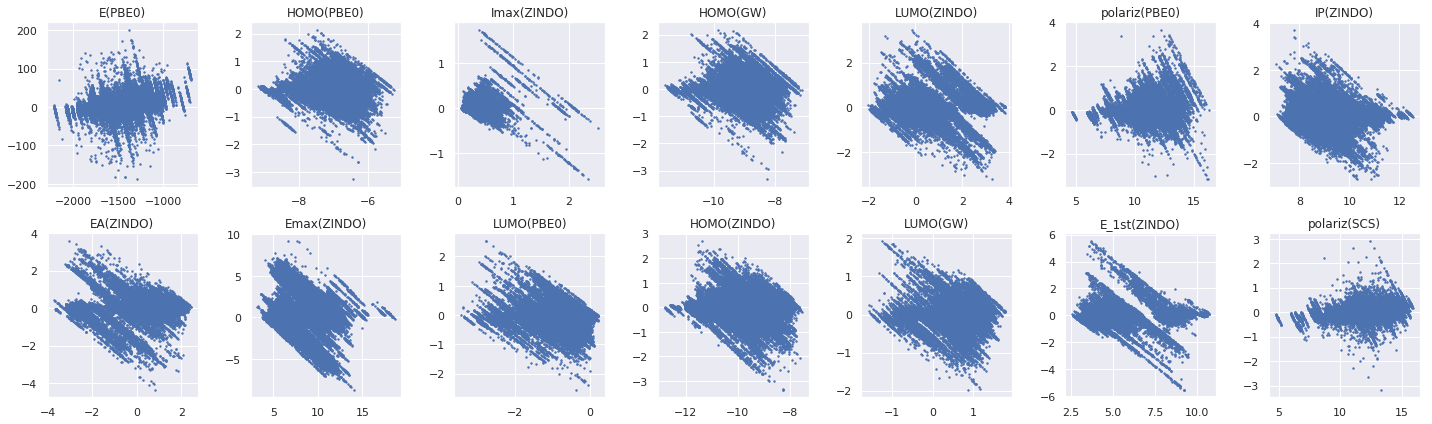

In [45]:
resid_plots = {target_cols[i]: [i % 2, i % 7] for i in range(14)}

fig, axes = plt.subplots(nrows=2, ncols=7)

for i, (k, v) in enumerate(resid_plots.items()):
    axes[resid_plots[k][0], resid_plots[k][1]].set_title(k)
    axes[resid_plots[k][0], resid_plots[k][1]].scatter(Y_val_preds[:, i], Y_val_unscaled[:, i] - Y_val_preds[:, i],
                                                      s=2)

plt.tight_layout()

for ax in fig.axes:
    plt.sca(ax)

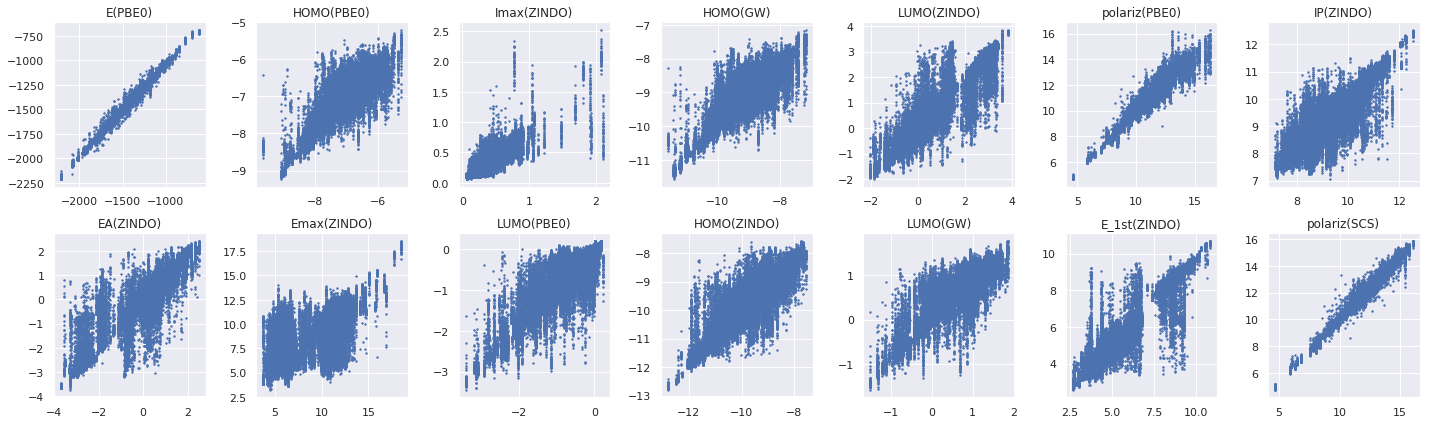

In [46]:
resid_plots = {target_cols[i]: [i % 2, i % 7] for i in range(14)}

fig, axes = plt.subplots(nrows=2, ncols=7)

for i, (k, v) in enumerate(resid_plots.items()):
    axes[resid_plots[k][0], resid_plots[k][1]].set_title(k)
    axes[resid_plots[k][0], resid_plots[k][1]].scatter(Y_val_unscaled[:, i], Y_val_preds[:, i],
                                                      s=2)

plt.tight_layout()

for ax in fig.axes:
    plt.sca(ax)

## Train mark2_nn
### Trained to min_delta of 0.0001 and patience of 1000

In [47]:
# nn_training_params['es_min_delta'] = 0.0001
# nn_training_params['es_patience'] = 1000

# mark2_nn = setup_and_train('mark2_nn', best_params, min_delta=nn_training_params['es_min_delta'],
#                            patience=nn_training_params['es_patience'])

In [48]:
# mark2_nn_history = mark2_nn.history.history.copy()
# with open('pickles/mark2_nn_history.pkl', 'wb') as f:
#     pickle.dump(mark2_nn_history, f)
#     f.close()

In [49]:
# mark2_nn = ensemble_epochs('mark2_nn')

>loaded model_checkpoints/mark2_nn.0.hdf5
>loaded model_checkpoints/mark2_nn.1.hdf5
>loaded model_checkpoints/mark2_nn.2.hdf5
>loaded model_checkpoints/mark2_nn.3.hdf5
>loaded model_checkpoints/mark2_nn.4.hdf5
>loaded model_checkpoints/mark2_nn.5.hdf5
>loaded model_checkpoints/mark2_nn.6.hdf5
>loaded model_checkpoints/mark2_nn.7.hdf5
>loaded model_checkpoints/mark2_nn.8.hdf5
>loaded model_checkpoints/mark2_nn.9.hdf5
Loaded 10 models
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1024)              542720    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024)              4096      
_________________________________________________________________
activation_1 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None,

## Save improved model

In [50]:
# with open('pickles/mark2_ensembled.pkl', 'wb') as f:
#     pickle.dump(mark2_nn, f)
#     f.close()

In [52]:
with open('pickles/mark2_ensembled.pkl', 'rb') as f:
    mark2_nn = pickle.load(f)
    f.close()

# Metrics for Mk2

In [53]:
print('Scaled MAE:', mean_absolute_error(Y_val_aug, mark2_nn.predict(X_val_aug)))
print('Scaled R^2:', r2_score(Y_val_aug, mark2_nn.predict(X_val_aug)))

Scaled MAE: 0.21134027220041213
Scaled R^2: 0.841255087705351


In [54]:
Y_val_preds = scaler.inverse_transform(mark2_nn.predict(X_val_aug))

for i in range(14):
    print('R^2', target_cols[i], r2_score(Y_val_unscaled[:, i], Y_val_preds[:, i]))

R^2 E(PBE0) 0.9937885313153483
R^2 Emax(ZINDO) 0.5979727654226226
R^2 Imax(ZINDO) 0.7552917980450969
R^2 HOMO(ZINDO) 0.8326701248610868
R^2 LUMO(ZINDO) 0.9010421633296445
R^2 E_1st(ZINDO) 0.9313390602084468
R^2 IP(ZINDO) 0.8126675454485006
R^2 EA(ZINDO) 0.8976073046506265
R^2 HOMO(PBE0) 0.7710984021873271
R^2 LUMO(PBE0) 0.831220489831163
R^2 HOMO(GW) 0.7688318748116512
R^2 LUMO(GW) 0.756170537516129
R^2 polariz(PBE0) 0.9426681586628488
R^2 polariz(SCS) 0.9852024734613413


<BarContainer object of 4 artists>

/home/bam/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


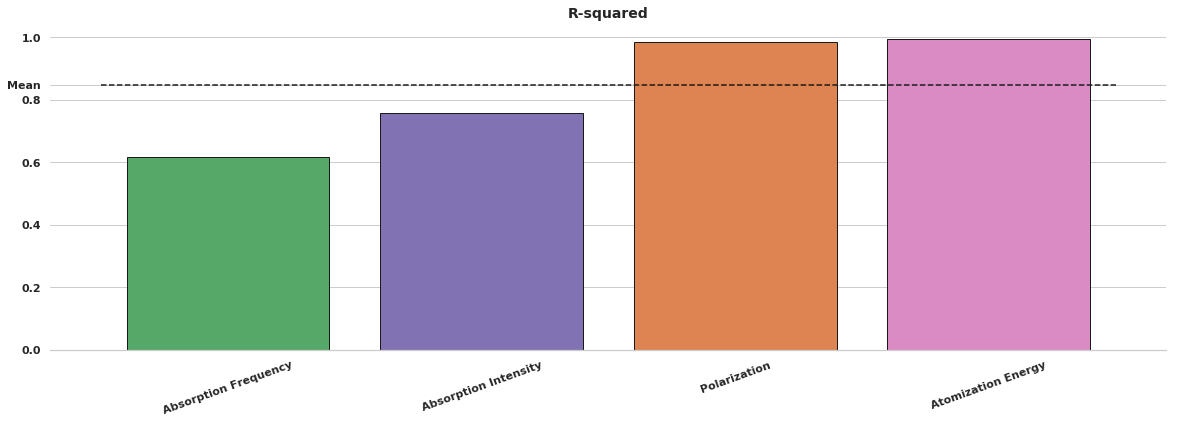

In [56]:
r_2s = [0.618, 0.758, 0.985, 0.993]
xticks = [i for i in range(len(r_2s))]
xlabels = ['Absorption Frequency', 'Absorption Intensity', 'Polarization', 'Atomization Energy']
colors = ['C2', 'C4', 'C1', 'C6']
mean_r_2 = 0.848

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)


sns.set_style('whitegrid')

plt.grid(b=False, axis='x')
figsize(8, 8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('R-squared', fontdict=font)
plt.xticks(ticks=xticks, labels=xlabels, rotation=20)
plt.yticks(ticks=[round(i * 0.2, 1) for i in range(6)] + [mean_r_2], labels=[round(i * 0.2, 1) for i in range(6)] + ['Mean'])
plt.hlines(mean_r_2, -0.5, len(r_2s) - 0.5, linestyles='dashed', label='Mean')
plt.bar(xticks, r_2s, edgecolor='k', color=colors)
# plt.savefig('R-squareds.png', format='png', bbox='tight');

## Test set metrics

In [57]:
print('Scaled MAE:', mean_absolute_error(Y_test_aug, mark2_nn.predict(X_test_aug)))
print('Scaled R^2:', r2_score(Y_test_aug, mark2_nn.predict(X_test_aug)))

Scaled MAE: 0.22159742712363342
Scaled R^2: 0.8295086264852103


In [58]:
Y_test_preds = scaler.inverse_transform(mark2_nn.predict(X_test_aug))
Y_test_unscaled = scaler.inverse_transform(Y_test_aug)

for i in range(14):
    print('R^2', target_cols[i], r2_score(Y_test_unscaled[:, i], Y_test_preds[:, i]))

R^2 E(PBE0) 0.9936918847366271
R^2 Emax(ZINDO) 0.5616172956336646
R^2 Imax(ZINDO) 0.6931431361836289
R^2 HOMO(ZINDO) 0.8134024877459702
R^2 LUMO(ZINDO) 0.8980564896580412
R^2 E_1st(ZINDO) 0.9237169041486718
R^2 IP(ZINDO) 0.8000460515295821
R^2 EA(ZINDO) 0.8961904460120574
R^2 HOMO(PBE0) 0.7789108512437237
R^2 LUMO(PBE0) 0.8139890834621585
R^2 HOMO(GW) 0.7726811717089014
R^2 LUMO(GW) 0.7398248678853794
R^2 polariz(PBE0) 0.9425222306179601
R^2 polariz(SCS) 0.9853278703707443


<BarContainer object of 4 artists>

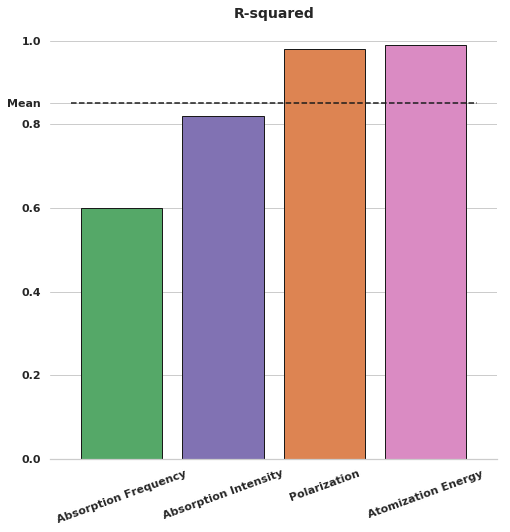

In [59]:
r_2s = [0.60, 0.82, 0.98, 0.99]
xticks = [i for i in range(len(r_2s))]
xlabels = ['Absorption Frequency', 'Absorption Intensity', 'Polarization', 'Atomization Energy']
colors = ['C2', 'C4', 'C1', 'C6']
mean_r_2 = 0.85

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)


sns.set_style('whitegrid')

plt.grid(b=False, axis='x')
figsize(8, 8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.title('R-squared', fontdict=font)
plt.xticks(ticks=xticks, labels=xlabels, rotation=20)
plt.yticks(ticks=[round(i * 0.2, 1) for i in range(6)] + [mean_r_2], labels=[round(i * 0.2, 1) for i in range(6)] + ['Mean'])
plt.hlines(mean_r_2, -0.5, len(r_2s) - 0.5, linestyles='dashed', label='Mean')
plt.bar(xticks, r_2s, edgecolor='k', color=colors)
# plt.savefig('R-squareds.png', format='png', bbox='tight');